# Predicting Death on the Titanic

This notebook aims to accurately predict the surviving and deceased passengers aboard the Titanic based on various attributes of each passenger.

We will train several Sklearn classification models on some training data and evaluate the accuracy of each one, we will then tune the hyperparameters of our best model and make predictions on the dataset given by Kaggle for testing.

The models we will try are:
* Logistic Regression
* RandomForestClassifier
* KNearestNeighbors

## Evaluation

The evaluation metric we will pay attention to is `Accuracy` as this is the metric Kaggle asked for, however we will also look at the:

* ROC curve and AUC
* Precision
* Recall
* F1 Score

## The Data

Data dictionary:

* survival 	Survival(0 = No, 1 = Yes)
* pclass 	Ticket class(1 = 1st, 2 = 2nd, 3 = 3rd)
* sex 	    Sex 	
* Age 	    Age in years 	
* sibsp 	# of siblings / spouses aboard the Titanic 	
* parch 	# of parents / children aboard the Titanic 	
* ticket 	Ticket number 	
* fare 	    Passenger fare 	
* cabin 	Cabin number 	
* embarked 	Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)

Variable notes:

* pclass: A proxy for socio-economic status (SES)
    1st = Upper, 
    2nd = Middle,
    3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Import the tools and libraries

# Regular EDA(exploratory data analysis) and plotting libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

#Models from Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [3]:
# import the data
df = pd.read_csv('data/train.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check what data types we are working with
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Check for null values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Preprocessing the data

Now that we can see there are some null values and non_numeric data in our dataframe we can preprocess our data before beginning our EDA and modelling.

We will write a function to handle this on the training data and then we can call the function again to perform the exact same preprocessing on the test data later on.

There are too many missing values in the "Cabin" column so we will just drop that column as well as the "Name" and "Ticket" columns. "PassengerID" can serve as a reference to the passenger and we don't really need the ticket numbers.

We can then encode the "Sex" and "Embarked" columns and fill their missing values.
We will fill the missing values of "Age" with the median of the other values and we can fill the 2 missing values in "Embarked" with 'N'.

In [84]:
# Create a function to preprocess the Titanic data

def preprocess_data(df):
    '''
    Performs transformations of the df and returns transformed df.
    '''
    # Drop the 'cabin', 'name' and 'ticket' columns
    features = ['Cabin', 'Name', 'Ticket']
    df.drop(features, axis=1, inplace=True)
    
    # Fill missing values of 'Age' and 'Embarked'
    df.Age.fillna(df.Age.median(), inplace=True)
    df.Fare.fillna(df.Fare.median(), inplace=True)
    df.Embarked.fillna('N', inplace=True)
    
    # Encode the 'sex' and 'embarked' columns
    features = ['Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    
    
    return df
    
    

In [7]:
df_train = preprocess_data(df)
df_train.head(50)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,3
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,3
3,4,1,1,0,35.0,1,0,53.1000,3
4,5,0,3,1,35.0,0,0,8.0500,3
5,6,0,3,1,28.0,0,0,8.4583,2
6,7,0,1,1,54.0,0,0,51.8625,3
7,8,0,3,1,2.0,3,1,21.0750,3
8,9,1,3,0,27.0,0,2,11.1333,3
9,10,1,2,0,14.0,1,0,30.0708,0


In [8]:
df_train.isna().sum()


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int32  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int32  
dtypes: float64(2), int32(2), int64(5)
memory usage: 55.8 KB


# Exploratory Data Analysis

We have processed our data and all features are in numeric form, irrelevent columns have been dropped from the data frame and missing values have been dealt with.

Now we can perform some EDA on our processed data.

We will look at the following:

* A correlation matrix 
* Survival rates in relation to sex
* Survival rates in relation to passenger class
* Survival rates in relation to passenger fare price(Did more people survive that paid a larger price for their fare)


## Correlation Matrix



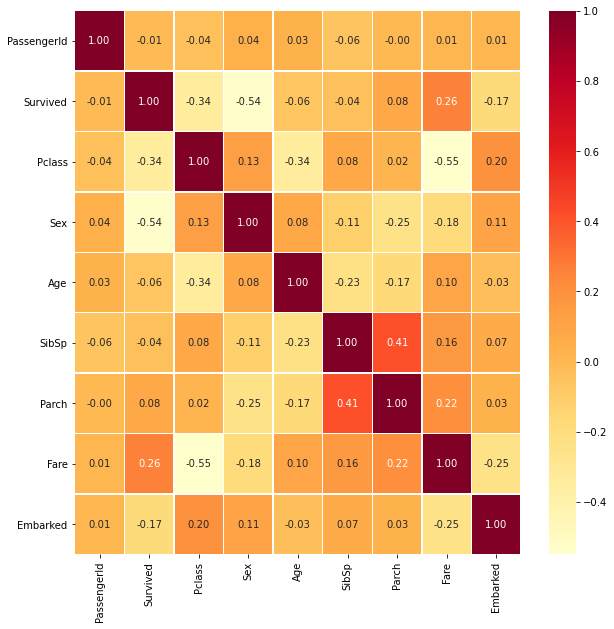

In [10]:
# Create a correlation matrix
corr_mat = df_train.corr()

# Make the corr_mat more visual with a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_mat,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap='YlOrRd');


## Survival Rates in Relation to Sex

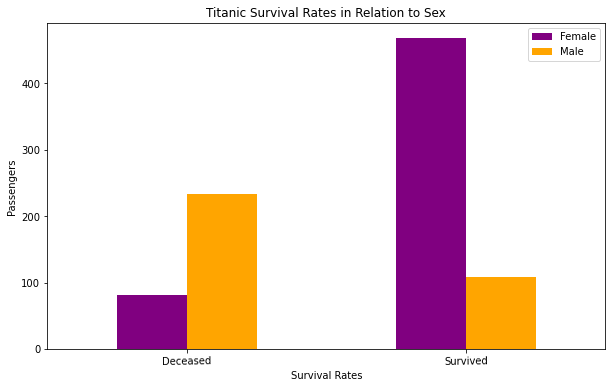

In [11]:
# Create a crosstab of the 'Sex' and 'Survived' columns
pd.crosstab(df_train.Sex, df_train.Survived).plot(kind='bar',
                                                  figsize=(10, 6),
                                                  color=['purple', 'orange'])

# Customise the plot
plt.title("Titanic Survival Rates in Relation to Sex")
plt.xlabel("Survival Rates")
plt.ylabel("Passengers")
plt.legend(["Female", "Male"])
plt.xticks([0, 1], ["Deceased", "Survived"], rotation=1);

It appears that more male passengers perished on the Titanic and that makes sense as it is known that women and children were given priority on the escape boats and the able bodied men would have probably been expected to assist the crew in evacuating the ship and searching for people trapped in the lower levels of the ship. This would have increased their probability of death.

Now we will look at 

## Survival Rates in Relation to Passenger Class

Whether the passengers in a higher travel class had a better survival rate than the passengers in the lower classes.
We will remind ourselves what the variables in the Pclass feature are:

* pclass: A proxy for socio-economic status (SES)
    1 = Upper, 
    2 = Middle,
    3 = Lower

We can see in the correlation matrix that there is a high negative correlation between 'Pclass' and 'Fare' but when we look at the data frame we can see a massive difference between what upperclass people paid for their ticket and what the lower classes paid for their's. Mostly a difference of up to and beyond 50 units of whatever currency the data is recorded in. In 1912, 50 units of currency in the western world was a substantial amount.
It can be assumed that passengers of a higher class would have had a better survival rate as they could have commanded priority of assistance over passengers of the lower class.
Hopefully during an event like that social status would have dematerialised and all passengers be treated as equally deserving to survive.
Let's look at the data...

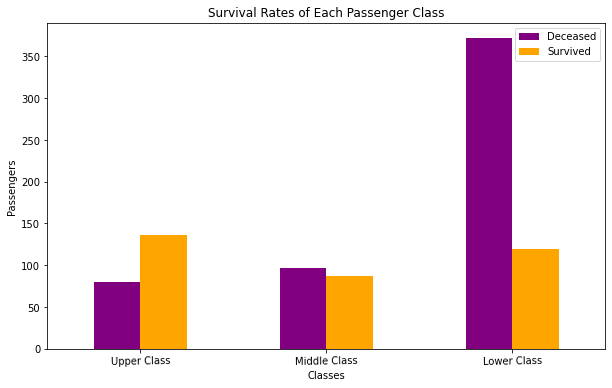

In [12]:
# Create a crosstab of the Passenger class types and survival rates
pd.crosstab(df_train.Pclass, df_train.Survived).plot(kind='bar',
                                                     figsize=(10, 6),
                                                     color=['purple', 'orange'])

# Customise the plot
plt.title("Survival Rates of Each Passenger Class")
plt.xlabel("Classes")
plt.ylabel("Passengers")
plt.legend(["Deceased", "Survived"])
plt.xticks([0, 1, 2], ["Upper Class", "Middle Class", "Lower Class"], rotation=1);

Well it looks as though our assumption was correct and most of the passengers that died aboard the Titanic were from the lower class. 

The next plot we will look at is

## Survival Rates in Relation to Fare Price

This will reiterate the pattern we discovered in the above 'Pclass' plot but let's look at it another way

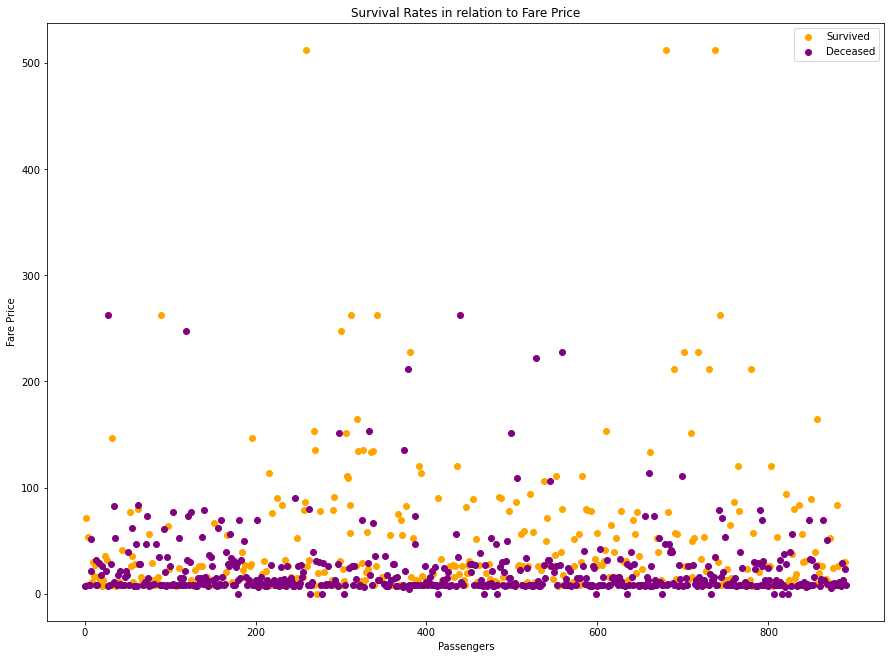

In [13]:
# Create a figure
plt.figure(figsize=(15, 11))

# Scatter with survival examples
plt.scatter(df_train.PassengerId[df_train.Survived == 1],
            df_train.Fare[df_train.Survived == 1],
            color='orange')

# Scatter with deceased examples
plt.scatter(df_train.PassengerId[df_train.Survived == 0],
            df_train.Fare[df_train.Survived == 0],
            color='purple')
# Add title, labels and legend
plt.title("Survival Rates in relation to Fare Price")
plt.xlabel("Passengers")
plt.ylabel("Fare Price")
plt.legend(["Survived", "Deceased"]);

## Survival Rates in Relation to Age.

Let's look at one more quick plot for fun.

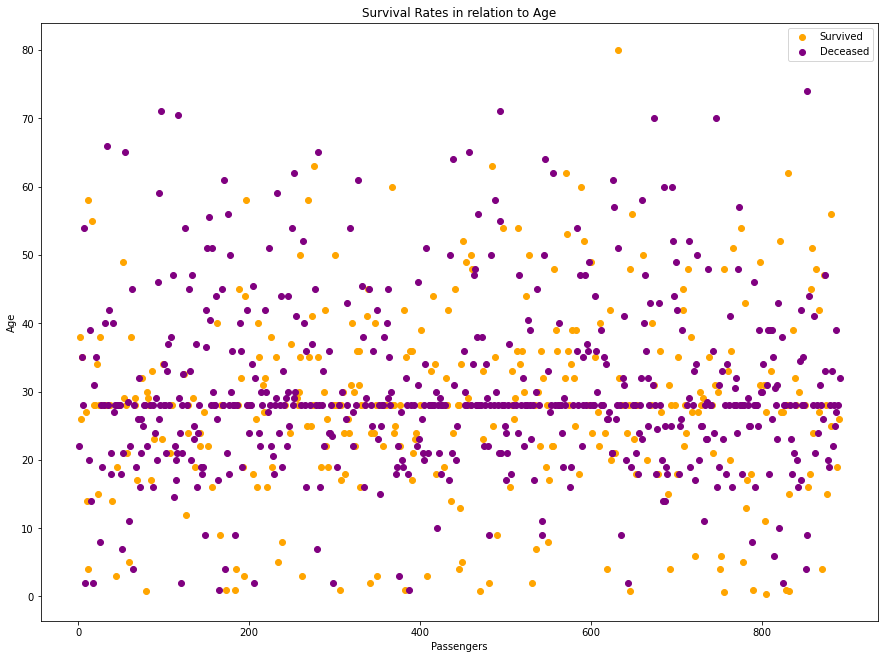

In [14]:
# Create a figure
plt.figure(figsize=(15, 11))

# Scatter with survival examples
plt.scatter(df_train.PassengerId[df_train.Survived == 1],
            df_train.Age[df_train.Survived == 1],
            color='orange')

# Scatter with deceased examples
plt.scatter(df_train.PassengerId[df_train.Survived == 0],
            df_train.Age[df_train.Survived == 0],
            color='purple')
# Add title, labels and legend
plt.title("Survival Rates in relation to Age")
plt.xlabel("Passengers")
plt.ylabel("Age")
plt.legend(["Survived", "Deceased"]);

## Modelling

Now it's time to train a model.

Actually we are going to train four:

* Linear SVC
* Logistic Regression
* Random Forest
* KNearest Neighbors

We wil then take the best performing model with the best accuracy score and tweak the hyperparameters and then fit the ideal model to a validation subset of the training data.

We can then import the test data and make some predictions.


In [16]:
# Split the data into X & y
X = df_train.drop('Survived', axis=1)
y = df_train.Survived

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 8), (179, 8), (712,), (179,))

In [34]:
# Create a dict of machine learning models
models = {
          'Linear SVC': LinearSVC(),
          'Logistic Regression': LogisticRegression(),
          'Random Forest Classo': RandomForestClassifier(),
          'KNN': KNeighborsClassifier()
         }

# Create a function to fit and score the models
def fit_and_score(models, X_train, X_val, y_train, y_val):
    '''
    Fits and evaluates given machine learning models with the accuracy metric.
    models: Dictionary of given models
    X_train: Training data(no labels)
    X_val: Validation data(no labels)
    y_train: Training labels
    y_val: Validation labels
    '''
    # Set up a random seed
    np.random.seed(42)
    
    # Create and empty dict to store the model scores
    model_scores = {}
    
    # Loop through the models
    for name, model in models.items():
        # Fit the model to the training data
        model.fit(X_train, y_train)
        # Evaluate the models and store in model_scores
        model_scores[name] = model.score(X_val, y_val)
    
    return model_scores

{'Linear SVC': 0.6927374301675978,
 'Logistic Regression': 0.7821229050279329,
 'Random Forest Classo': 0.8268156424581006,
 'KNN': 0.659217877094972}

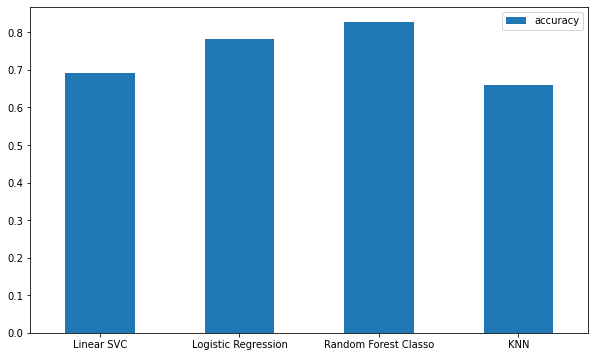

In [35]:
model_scores = fit_and_score(models,
                             X_train,
                             X_val,
                             y_train,
                             y_val)
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(figsize=(10, 6),
                         rot=0);

model_scores

It looks like the Random Forest model is our best baseline model.
Let's tune it's hyperparameters and see if we can squeeze out a better score.

For this particular exercise we will use RandomizedSearchCV to find an optimum set of hyperparameters for the RandomForest model.

In [49]:
%%time
# Create a hyperparam grid with a dictionary
rf_grid = {
           'criterion': ['gini', 'entropy'],
           'max_depth': np.arange(5, 51, 1),
           'min_samples_split': np.arange(2, 6, 1),
           'n_estimators': np.arange(200, 501, 100)
          }
# Instantiate the RandomizedSearchCV
rs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                           param_distributions= rf_grid,
                           n_iter=50,
                           scoring='accuracy',
                           n_jobs= -1)

# Fit to the training data
rs_rf.fit(X_train, y_train)

Wall time: 41.8 s


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'min_samples_split': array([2, 3, 4, 5]),
                                        'n_estimators': array([200, 300, 400, 500])},
                   scoring='accuracy')

In [50]:
# Check for the best parameter settings
rs_rf.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'max_depth': 25,
 'criterion': 'gini'}

In [71]:
# Train a new RandomForest model using these best hyperparameters
models = {'Random Forest': RandomForestClassifier(random_state=42,
                                                  n_estimators=500,
                                                  criterion='entropy',
                                                  max_depth=50,
                                                  min_samples_split= 4,
                                                  max_samples=712,
                                                  n_jobs=-1,
                                                  verbose=1)
        }

# Run the fit and score function with the new model
model_scores = fit_and_score(models, X_train, X_val, y_train, y_val)
model_scores

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


{'Random Forest': 0.8324022346368715}

It looks like this is the best we will get this model.

Our Random Forest Classifier predicts at an accuracy of 83.24%

Now we can

## Make Predictions on the test data

In [89]:
# Import the test data and preprocess
test_data = pd.read_csv('data/test.csv')

# Run the preprocessing function on the test data and return a new DataFrame
df_test = preprocess_data(test_data)

In [95]:
# Use our trained model to make predictions
best_model = RandomForestClassifier(random_state=42,
                                    n_estimators=500,
                                    criterion='entropy',
                                    max_depth=50,
                                    min_samples_split= 4,
                                    max_samples=712,
                                    n_jobs=-1)
best_model.fit(X_train, y_train)
best_model.score(X_val, y_val)
test_preds = best_model.predict(df_test)


In [96]:
# Format the predicted labels into a data frame and export as a .csv file
submission = pd.DataFrame({
                           'PassengerId': df_test.PassengerId,
                           'Survived': test_preds
                         })
submission.to_csv('submission.csv', index=False)

submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
